# Plotting Example

You can use our plot_rtos_log function to plot what the scheduler is doing over time. We have included a sample plot here, but you can also take your own data by copy-pasting the log output from Renode into sample_data.txt.

In [1]:
# Run this to automatically check for updates to the .txt data
%load_ext autoreload
%autoreload 2

Generate a plot using sample_data.txt.

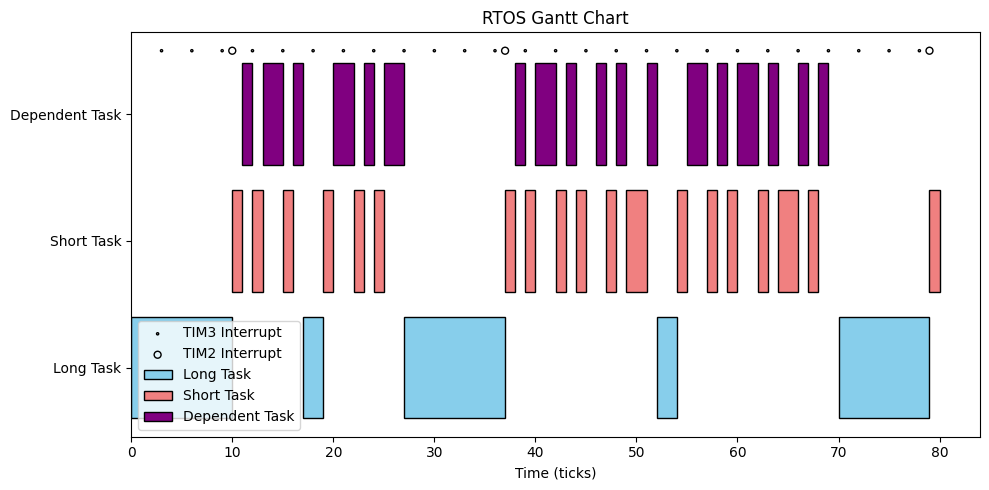

In [3]:
from plot import plot_rtos_log

plot_rtos_log("sample_data.txt")